# The Bias-Variance Trade-off

Here, we will cover the remaining elements of logistic regression, including what happens when you call *.fit* to train the model, and the statistical assumptions to be aware of when using this technique. We will learn how to use L1 and L2 regularization with logistical regression to prevent overfitting, and how to use cross-validation to decide the regularization strength.

## Estimating the Coefficients and Intercepts of Logistic Regression

This is done through the process of parameter estimation. When parameter estimation is done, the logistic regression model becomes essentially a finished product. How does it work though? We shall start to explain that by familiarizing ourselves with the cost function. A cost function is a method of telling how far away the model predictions are from perfectly describing the data. The larger the cost, the larger the difference betwen predicted data and actual data.

A typical cost function for classification problems (especially in fitting logistic regression models) is the log-loss function. A modified version of this function is used by skikit-learn to fit logistic regression.

## Gradient Descent to Find Optimal Parameter Values

The problem of finding parameter values for a logistic regression model using log-loss boils down to a problem of optimization. We want the set of parameters that results in the lowest cost, the "least-wrong" set of parameters on average over all the training samples. The *.fit* method does this for us automatically. Different techniques can be selected using the *solver* keyword when you instantiate the model class. All of these methods work differently from each other, but are all based on the concept of gradient descent.

The gradient descent process starts with an initial guess. The choice of the initial guess is not that important for logistic regression and you don't need to make it manually; this is handled by the *solver* keyword. However, for more advanced machine learning algorithms such as deep neural networks, selection of the initial guesses for parameters requires more attention.

In [1]:
#Consider hypothetical cost function y = f(x) = x^2 - 2x
import numpy as np
X_poly = np.linspace(-3,5,81)
print(X_poly[:5], '...', X_poly[-5:])

[-3.  -2.9 -2.8 -2.7 -2.6] ... [4.6 4.7 4.8 4.9 5. ]


Text(0.5, 1.0, 'Error surface')

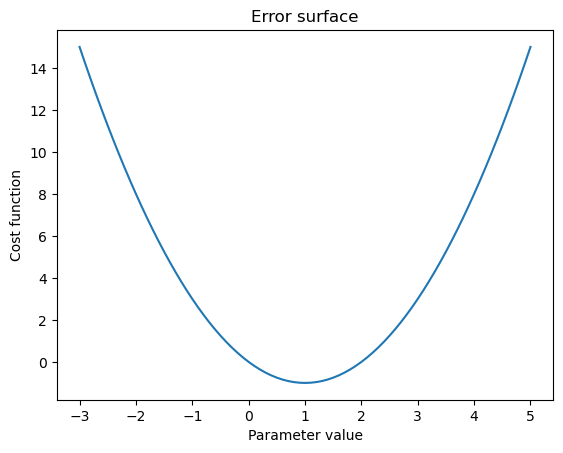

In [2]:
#Plot cost function
import matplotlib.pyplot as plt
def cost_function(X):
    return X * (X-2)
y_poly = cost_function(X_poly)
plt.plot(X_poly, y_poly)
plt.xlabel('Parameter value')
plt.ylabel('Cost function')
plt.title('Error surface')

## Using Gradient Descent to Minimize a Cost Function

The task here is to find the best set of parameters to minimize our above hypothetical cost function. This is done as follows:

[-3.  -2.9 -2.8 -2.7 -2.6] ... [4.6 4.7 4.8 4.9 5. ]


Text(0.5, 1.0, 'Error surface')

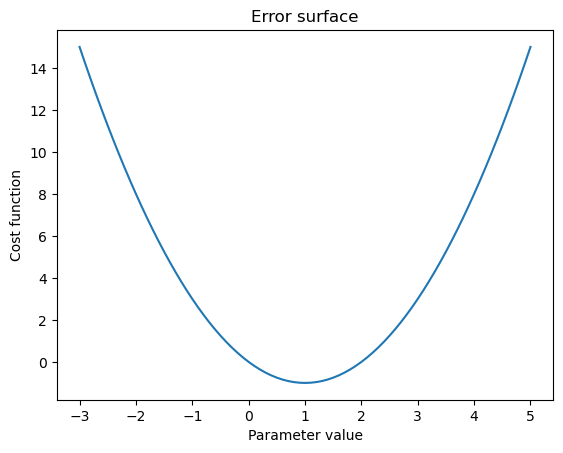

In [3]:
#Compare the Cost Function over a range of parameters
X_poly = np.linspace(-3,5,81)
print(X_poly[:5], '...', X_poly[-5:])
def cost_function(X):
    return X * (X-2)
y_poly = cost_function(X_poly)
plt.plot(X_poly, y_poly)
plt.xlabel('Parameter value')
plt.ylabel('Cost function')
plt.title('Error surface')

In [4]:
#Function for the value of the gradient
def gradient(X):
    return (2*X) - 2
x_start = 4.5
learning_rate = 0.75
x_next = x_start - gradient(x_start)*learning_rate
x_next

-0.75

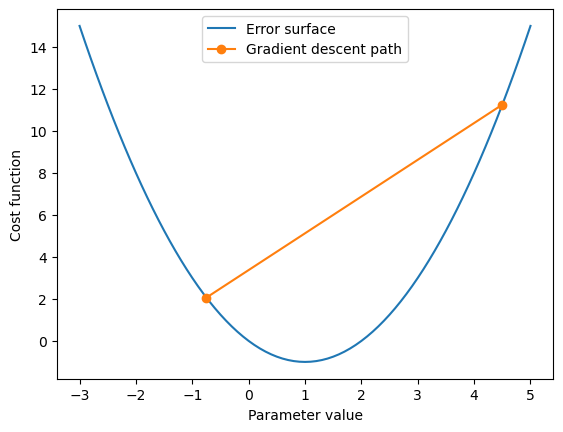

In [5]:
#Plot Gradient Descent Path - 1 iteration
plt.plot(X_poly, y_poly)
plt.plot([x_start, x_next],
[cost_function(x_start), cost_function(x_next)],
'-o')
plt.xlabel('Parameter value')
plt.ylabel('Cost function')
plt.legend(['Error surface', 'Gradient descent path'])

In [6]:
#14 iterations of the Gradient Descent Path
iterations = 15
x_path = np.empty(iterations,)
x_path[0] = x_start
for iteration_count in range (1,iterations):
    derivative = gradient(x_path[iteration_count-1])
    x_path[iteration_count] = x_path[iteration_count-1] - (derivative*learning_rate)
x_path

array([ 4.5       , -0.75      ,  1.875     ,  0.5625    ,  1.21875   ,
        0.890625  ,  1.0546875 ,  0.97265625,  1.01367188,  0.99316406,
        1.00341797,  0.99829102,  1.00085449,  0.99957275,  1.00021362])

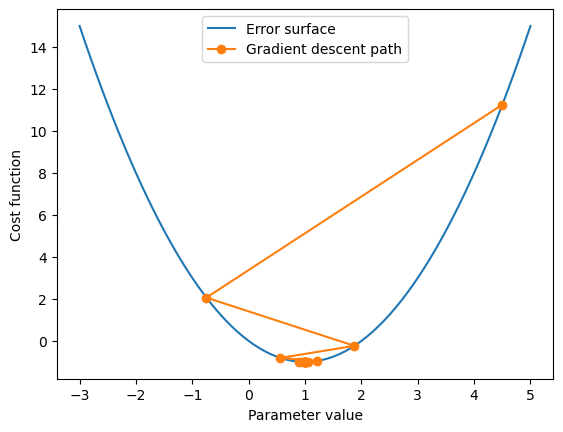

In [7]:
plt.plot(X_poly, y_poly)
plt.plot(x_path, cost_function(x_path), '-o')
plt.xlabel('Parameter value')
plt.ylabel('Cost function')
plt.legend(['Error surface', 'Gradient descent path'])

## Assumptions of Logistic Regression

- Features are linear in the log odds

- No multicolinearity of features -> the features are not correlated with each other.

- The observations/samples are assumed to be independent.

- There are no outliers.

## The Motivation for Regularization: The Bias-Variance Trade-Off

### Generating and Modeling Synthetic Classification Data

In [8]:
#Setup
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [9]:
#Generate Synthetic dataset with 1000 samples and 200 features
X_synthetic, y_synthetic = make_classification(
    n_samples=1000, n_features=200,
    n_informative=3, n_redundant=10,
    n_repeated=0, n_classes=2,
    n_clusters_per_class=2,
    weights=None, flip_y=0.01,
    class_sep=0.8, hypercube=True,
    shift=0.0, scale=1.0,
    shuffle=True, random_state=24)

In [10]:
#Examine shape of dataset and class fraction of response variable
print(X_synthetic.shape, y_synthetic.shape)
print(np.mean(y_synthetic))

(1000, 200) (1000,)
0.501


The synthetic dataset is almost perfectly balanced, and they have the same shift and scale - a mean of 0 and a standard deviation of 1. It is important to make sure these features are on the same scale/order of magnitude when using regularization methods. If features in a raw dataset are on widely different scales, they should be normalized to ensure that they're on the same scale.

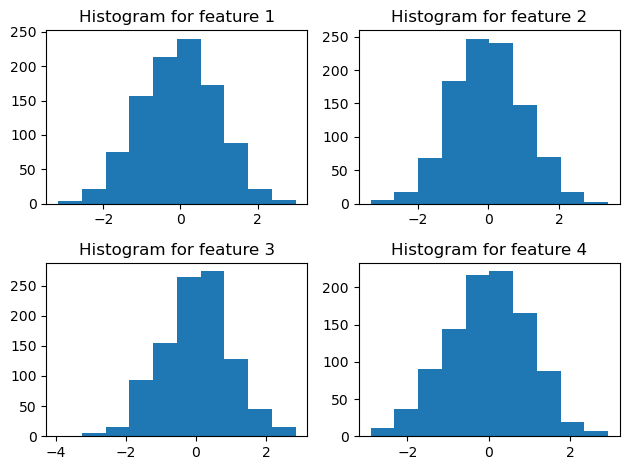

In [11]:
#Plot the first few features as histograms
for plot_index in range(4):
    plt.subplot(2, 2, plot_index+1)
    plt.hist(X_synthetic[:, plot_index])
    plt.title('Histogram for feature {}'.format(plot_index+1))
plt.tight_layout()

What are the possible concerns with a dataset? 

- If the data is unbalanced, one may need to undersample, oversample or use other methods that are helpful for imbalanced data? 

- What about the relationships between the features themselves and the features and the response variable? 

- Based on the rule of thumb (1 feature for every 10 samples of the rarest class), 200 features is too many. We have 500 observations in the rarest class, so only 50 features are needed.

- With so many features, it is possible that the model training procedure will overfit. There are options in the scikit-learn logistic regression to prevent this.

In [12]:
#train/test split + Logistic Regression
X_syn_train, X_syn_test, y_syn_train, y_syn_test = \
train_test_split(X_synthetic, y_synthetic,\
test_size=0.2, random_state=24)
lr_syn = LogisticRegression(solver='liblinear', penalty='l1',
C=1000, random_state=1)
lr_syn.fit(X_syn_train, y_syn_train)

LogisticRegression(C=1000, penalty='l1', random_state=1, solver='liblinear')

In this case, we have specified l1 regularization aka lasso regularization. And the C parameter is set to 1000. C is the inverse of regularization strength, according to the scikit-learn documentation. The default value is 1. The higher C is, the less regularization is performed. Therefore, we are not performing a lot of regularization.

In [13]:
#Fit the logistic regression model
lr_syn.fit(X_syn_train, y_syn_train)

LogisticRegression(C=1000, penalty='l1', random_state=1, solver='liblinear')

In [14]:
#Calculate training score via predicted probabilities and ROC AUC
y_syn_train_predict_proba = lr_syn.predict_proba(X_syn_train)
roc_auc_score(y_syn_train, y_syn_train_predict_proba[:,1])

0.9420000000000001

In [15]:
#Calculate the test score
y_syn_test_predict_proba = lr_syn.predict_proba(X_syn_test)
roc_auc_score(y_syn_test, y_syn_test_predict_proba[:,1])

0.8075807580758075

The regression model has overfit the data. This is shown by the ROC AUC score for the training data being significantly higher than that of the test data. This needs to be addressed.

## Lasso (L1) and Ridge (L2) Regularization

The two ways to regularize logistic regression models using scikit-learn are lasso and ridge regression. When instantiating the model object from the scikit-learn class, you can choose l1 or l2 as the value for the penality paramater. It is called the penality parameter because the effect of regularization is to add a penalty, or
a cost, for having larger values of the coefficients in a fitted logistic regression model.

As previously stated, coefficients in a logistic regression model describe the relationship between the log odds of the response and each of the features. Therefore, if a coefficient value is particularly large, then a small change in that feature will have a large effect on the prediction. When a model is being fit and is learning the relationship between features and the response variable, the model can start to learn the noise in the data.

If there are many features available when fitting a model, and there are no guardrails on the values that their coefficients can take, then the model fitting process may try to discover relationships between the features and the response variable that won't generalize to new data. In this way, the model becomes tuned to the unpredictable, random noise that accompanies real-world, imperfect data. Unfortunately, this only serves to increase the model's skill at predicting the training data, which is not our ultimate goal. Therefore, we should seek to root out such spurious relationships from the model.

## The Importance of Selecting the Right Solver

The different solvers in scikit-learn have different behaviours regarding the following:

- Whether they support both L1 and L2 regularization

- How they treat the intercept during regularization

- How they deal with unscaled data

To summarize this section, we have learned the mathematical foundations of lasso and ridge regularization. These methods work by shrinking the coefficient values toward 0, and in the case of the lasso, setting some coefficients to exactly 0 and thus performing feature selection. You can imagine that in our example of overfitting above, if the complex, overfitted model had some coefficients shrunk toward 0, it would look more like the ideal model, which has fewer coefficients.

## Model and Feature Selection

L1 regularization is one way to use a model, such as logistic regression, to perform feature selection. Other methods include forward or backward stepwise selection from the pool of candidate features. Here is the high-level idea behind these methods: in the case of forward selection, features are added to the model one at a time, and the out-of-sample performance is observed along the way. At each iteration, the addition of all possible features from the candidate pool is considered, and the one resulting in the greatest increase in the out-of-sample performance
is chosen. When adding additional features ceases to improve the model's performance, no more features need to be added from the candidates. In the case of backward selection, you first start with all the features in the model and determine which one you should remove: the one resulting in the smallest decrease in the out-of-sample performance. You can continue removing features in this way until the performance begins to decrease appreciably.

## Cross-Validation: Choosing the Regularization Parameter

How do we choose the regularization parameter, C? C is a model hyperparameter. Hyperparameters are different from the parameters that are estimated when a model is trained, such as the coefficients and the intercept of a logistic regression. Rather than being estimated by an automated procedure like the parameters are, hyperparameters are input directly by the user as keyword arguments, typically when instantiating the model class. So, how do we know what values to choose?

Hyperparameters are more difficult to estimate than parameters. This is because it is up to the data scientist to determine what the best value is, as opposed to letting an optimization algorithm find it. However, it is possible to programmatically choose hyperparameter values, which could be viewed as an optimization procedure in its own right. Practically speaking, in the case of the regularization parameter C, this is most commonly done by fitting the model on one set of data with a particular value of C, determining model training performance, and then assessing the out-of-sample performance on another set of data. 

We are already familiar with the concept of using model training and test sets. However, there is a key difference here; for instance, what would happen if we were to use the test set multiple times in order to see the effect of different values of C?

It may occur to you that after the first time you use the unseen test set to assess the out-of-sample performance for a particular value of C, it is no longer an "unseen" test set. While only the training data was used for estimating the model parameters (that is, the coefficients and the intercept), now the test data is being used to estimate the hyperparameter C. Effectively, the test data has now become additional training data in the sense that it is being used to find a good value for the hyperparameter.

For this reason, it is common to divide the data into three parts: a training set, a test set, and a validation set. The validation set serves multiple purposes:

- Estimating Hyperparameters

- Estimating the out-of-sample performance of different models

## Data Management Best Practices - VERY IMPORTANT

As a data scientist, it's up to you to figure out how to divide up your data for different predictive modeling tasks. In the ideal case, you should reservea portion of your data for the very end of the process, after you've already selected model hyperparameters and also selected the best model. This unseen test set is reserved for the last step, when it can be used to assess the endpoint of your model-building efforts, to see how the final model generalizes to new unseen data. When reserving the test set, it is good practice to make sure that the features and responses have similar characteristics to the rest of the data. In other words, the class fraction should be the same, and the distribution of features should be similar.This way, the test data should be representative of the data you built the model with.

While model validation is a good practice, it raises the question of whether the particular split we choose for the training, validation, and test data has any effect on the outcomes that we are tracking. For example, perhaps the relationship between the features and the response variable is slightly different in the unseen test set that
we have reserved, or in the validation set, versus the training set. It is likely impossible to eliminate all such variability, but we can use the method of cross-validation to avoid placing too much faith in one particular split of the data.

Scikit-learn provides convenient functions to facilitate cross-validation analyses. These functions play a similar role to train_test_split, which we have already been using, although the default behavior is somewhat different. Let's get familiar with them now. 

In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold #import libraries for k-cross validation

In [30]:
n_folds = 4 #each fold is 25% of the data
k_folds = KFold(n_splits=n_folds, shuffle=False) #no shuffling, #k_folds is the base for the iterator

In [31]:
def plot_kfolds(k_folds_iterator):
    fold_counter = 0
    for train_index, test_index in k_folds_iterator.split(X_syn_train,
                                                          y_syn_train):

        #Axis to hold the plot of this fold
        ax = plt.subplot(n_folds,1,fold_counter+1)

        #Background rectangle representing all samples
        n_train_samples = len(y_syn_train)
        rect = mpl.patches.Rectangle(xy=(0,0), width=n_train_samples, height=1)
        ax.add_patch(rect)

        #Plot each testing sample from this fold as a vertical line
        for this_text_ix in test_index:
            ax.plot([this_text_ix, this_text_ix], [0, 1], color=cmap(1),
                    linewidth=0.75)

        #Plot formatting
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(0, n_train_samples)
        ax.set_ylim(0,1)
        
        #Subplot titles
        if fold_counter == 0:
            ax.text(0.26, 1.2, 'Training data,',
                    transform=ax.transAxes, backgroundcolor = cmap(0))
            ax.text(0.45, 1.2, 'testing data:',
                    transform=ax.transAxes, backgroundcolor = cmap(1))
            ax.text(0.62, 1.2, 'fold {}'.format(fold_counter+1), transform=ax.transAxes)
        else:
            ax.text(0.45, 1.2, 'Fold {}'.format(fold_counter+1), transform=ax.transAxes)

        fold_counter += 1

    plt.tight_layout()

In [32]:
import matplotlib as mpl
import sys
import seaborn as sns
cmap = mpl.cm.get_cmap('tab10')

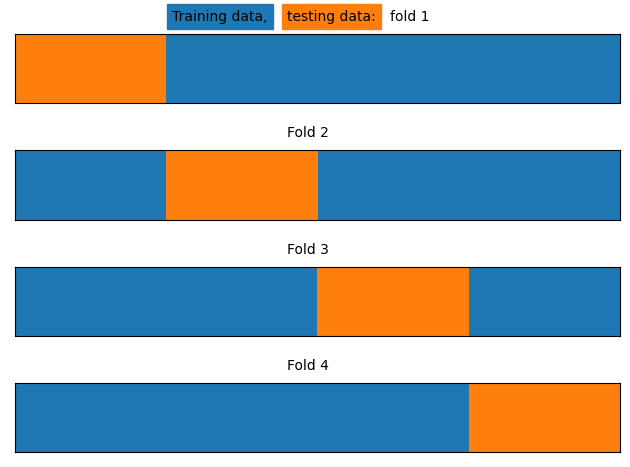

In [33]:
plot_kfolds(k_folds)

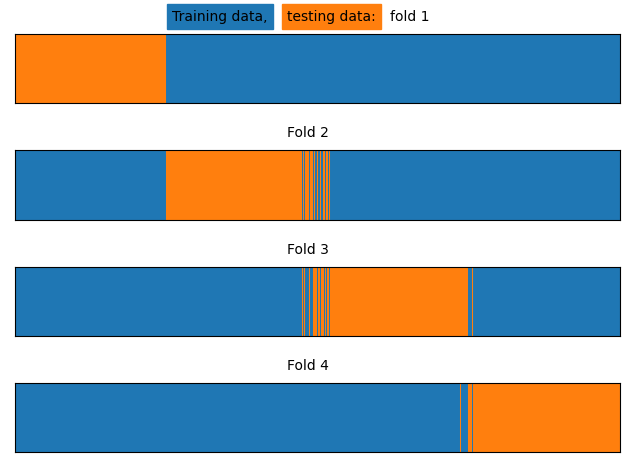

In [35]:
k_folds = StratifiedKFold(n_splits=n_folds, shuffle=False) #Stratified K_folds
plot_kfolds(k_folds)

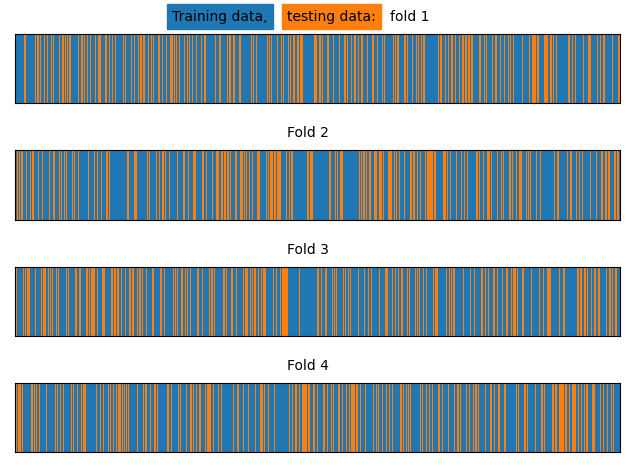

In [36]:
k_folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1) #Stratified K_folds with random shuffle
plot_kfolds(k_folds)

## Reducing Overfitting on a Synthetic Data Classification Problem

In [37]:
#Goal here: Vary C from 1000 to 0.001
C_val_exponents = np.linspace(3,-3,13)
C_val_exponents

array([ 3. ,  2.5,  2. ,  1.5,  1. ,  0.5,  0. , -0.5, -1. , -1.5, -2. ,
       -2.5, -3. ])

In [38]:
#Vary C by Powers of 10
C_vals = np.float(10)**C_val_exponents
C_vals

/tmp/ipykernel_3547/1664097724.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  C_vals = np.float(10)**C_val_exponents


array([1.00000000e+03, 3.16227766e+02, 1.00000000e+02, 3.16227766e+01,
       1.00000000e+01, 3.16227766e+00, 1.00000000e+00, 3.16227766e-01,
       1.00000000e-01, 3.16227766e-02, 1.00000000e-02, 3.16227766e-03,
       1.00000000e-03])

In [39]:
#ROC Curve
from sklearn.metrics import roc_curve

In [45]:
#Explore different amounts of regularization with k-fold cross validation
def cross_val_C_search(k_folds, C_vals, model, X, Y):
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals))) #Arrays hold perfomance data 

In [46]:
#Store arrays of true and false positive rates, and thresholds that go with each ROC AUC score in a list of lists
cv_test_roc = [[]]*len(C_vals)

In [48]:
def cross_val_C_search(k_folds, C_vals, model, X, Y):
    
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc = [[]]*len(C_vals)

    for c_val_counter in range(len(C_vals)):
        #Set the C value for the model object
        model.C = C_vals[c_val_counter]
        #Count folds for each value of C
        fold_counter = 0
        #Get training and testing indices for each fold
        for train_index, test_index in k_folds.split(X, Y):
            #Subset the features and response, for training and testing data for
            #this fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]

            #Fit the model on the training data
            model.fit(X_cv_train, y_cv_train)

            #Get the training ROC AUC
            y_cv_train_predict_proba = model.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])

            #Get the testing ROC AUC
            y_cv_test_predict_proba = model.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])

            #Testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)

            #Increment the fold counter
            fold_counter += 1

        #Indicate progress
        print('Done with C = {}'.format(lr_syn.C))

    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

In [49]:
#Results
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search(k_folds, C_vals, lr_syn, X_syn_train, y_syn_train)

Done with C = 1000.0
Done with C = 316.22776601683796
Done with C = 100.0
Done with C = 31.622776601683793
Done with C = 10.0
Done with C = 3.1622776601683795
Done with C = 1.0
Done with C = 0.31622776601683794
Done with C = 0.1
Done with C = 0.03162277660168379
Done with C = 0.01
Done with C = 0.0031622776601683794
Done with C = 0.001


Text(0.5, 1.0, 'Cross validation scores for each fold')

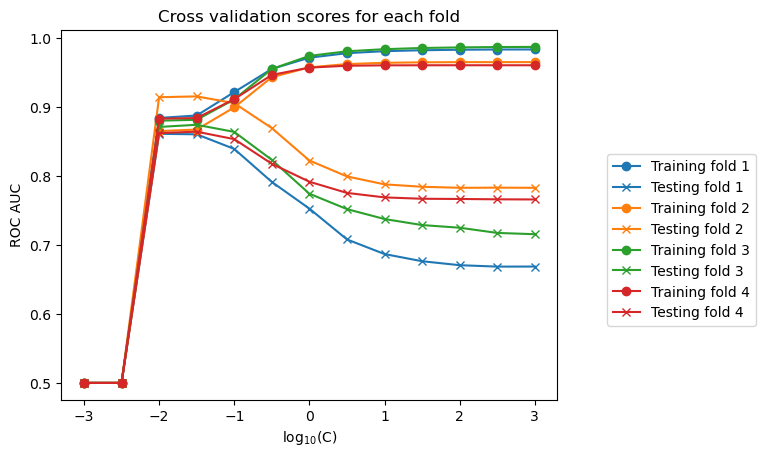

In [50]:
#Loop over each fold to view the results individually
for this_fold in range(k_folds.n_splits):
    plt.plot(C_val_exponents, cv_train_roc_auc[this_fold], '-o',color=cmap(this_fold),\
    label='Training fold {}'.format(this_fold+1))
    plt.plot(C_val_exponents, cv_test_roc_auc[this_fold], '-x',color=cmap(this_fold),\
    label='Testing fold {}'.format(this_fold+1))
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend(loc = [1.1, 0.2])
plt.title('Cross validation scores for each fold')

C values of $10^{-1.5}$ and $10^{-2}$ have similar test performances, all of which are much higher than the test performance of C = $10^{3}$. Regularization appears to have addressed our overfitting problem.

Text(0.5, 1.0, 'Cross validation scores averaged over all folds')

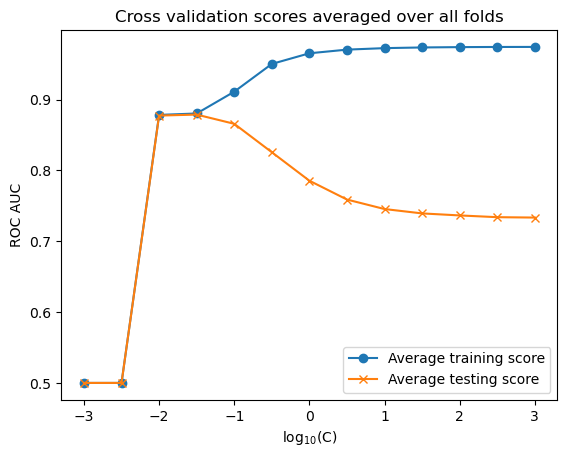

In [51]:
#Plot mean of test and training ROC AUC scores for each C value
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o', label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x', label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation scores averaged over all folds')

This confirms that C = $10^{-1.5}$ and C = $10^{-2}$ are the best scores due to the near absence of overfitting. We will use C = $10^{-1.5}$ from now on for this data.

Now to find the index of the outer list we made that corresponds to C = $10^{-1.5}$.

In [52]:
best_C_val_bool = C_val_exponents == -1.5
best_C_val_bool.astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [53]:
#Convert the integer version of the Boolean array into a single integer index
best_C_val_ix = np.nonzero(best_C_val_bool.astype(int)) 
best_C_val_ix[0][0]

9

The C value we want to use is C = 9

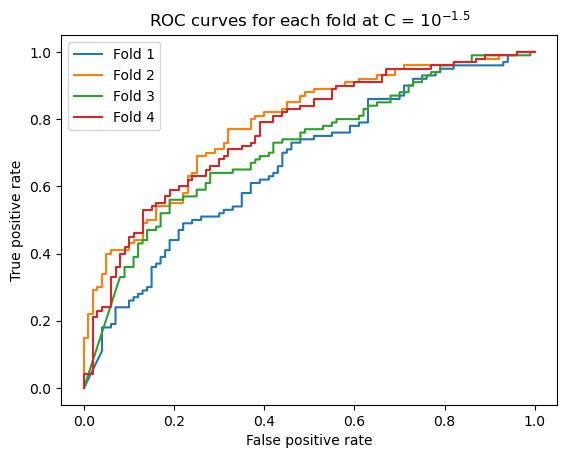

In [55]:
#Plot ROC Curves for each fold
for this_fold in range(k_folds.n_splits):
    fpr = cv_test_roc[best_C_val_ix[0][0]][this_fold][0]
    tpr = cv_test_roc[best_C_val_ix[0][0]][this_fold][1]
    plt.plot(fpr, tpr, label='Fold {}'.format(this_fold+1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves for each fold at C = $10^{-1.5}$')
plt.legend()

In [56]:
#Train the logistoc regresion on the training data from our synthetic problem. Compare test and train scores
lr_syn.C = 10**(-1.5)
lr_syn.fit(X_syn_train, y_syn_train)

LogisticRegression(C=0.03162277660168379, penalty='l1', random_state=1,
                   solver='liblinear')

In [57]:
#Predicted probabilities and ROC AUC for training data
y_syn_train_predict_proba = lr_syn.predict_proba(X_syn_train)
roc_auc_score(y_syn_train, y_syn_train_predict_proba[:,1])

0.8802812499999999

In [58]:
#Predicted probabilities and ROC AUC for test data
y_syn_test_predict_proba = lr_syn.predict_proba(X_syn_test)
roc_auc_score(y_syn_test, y_syn_test_predict_proba[:,1])

0.8847884788478848

The test score is above the training score - the overfitting problem has been greatly reduced! 

## Scaling Data, Pipelines, and Interaction Features in Scikit-learn

### Scaling Data

The case study data is a lot larger than the synthetic data we worked with. In order to use L1 regularization, we ought to use the ``saga`` solver. However, it is not robust to unscaled datasets. Which means we need to scale the data, which is good practice anyway when doing regularization. This ensures thaty all features are on the same scale and are equally penalized during the process. Using ``MinMaxScaler`` ensures this for us.

In [62]:
#Set up Case Study Data
import pandas as pd
df = pd.read_csv('/home/joseph/python_projects/Chapter_1_cleaned_data.csv')
features_response = df.columns.tolist()

In [63]:
features = features_response[:-1]
features

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month',
 'EDUCATION_CAT',
 'graduate school',
 'high school',
 'others']

In [64]:
X = df[features].values

#Make a test-train split
X_train, X_test, y_train, y_test = train_test_split(X, df['default payment next month'].values,
test_size=0.2, random_state=24)

In [65]:
from sklearn.preprocessing import MinMaxScaler
min_max_sc = MinMaxScaler()

In [66]:
lr = LogisticRegression(solver='saga', penalty='l1', max_iter=1000)

### Pipelines

Now that we are scaling data, what new considerations are there? We do not know the new max and min values of the scaled data. So, following the philosophy of making cross-validation an effective indicator of model performance on unseen data, we need to use the minimum and maximum values of the training data in each cross-validation fold in order to scale the test data in that fold, before making predictions on the test data. The ``Pipeline`` feature of scikit-learn is how we do this. It has two steps: The scaler and the logistic regression model.

In [67]:
from sklearn.pipeline import Pipeline
scale_lr_pipeline = Pipeline(steps=[('scaler', min_max_sc),('model', lr)])

In [68]:
#Get parameters
scale_lr_pipeline.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('model', LogisticRegression(max_iter=1000, penalty='l1', solver='saga'))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'model': LogisticRegression(max_iter=1000, penalty='l1', solver='saga'),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'model__C': 1.0,
 'model__class_weight': None,
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__l1_ratio': None,
 'model__max_iter': 1000,
 'model__multi_class': 'auto',
 'model__n_jobs': None,
 'model__penalty': 'l1',
 'model__random_state': None,
 'model__solver': 'saga',
 'model__tol': 0.0001,
 'model__verbose': 0,
 'model__warm_start': False}

In [69]:
scale_lr_pipeline.set_params(model__C = 2)
C_val_exponents = np.linspace(2,-3,6)
C_vals = np.float(10)**C_val_exponents

/tmp/ipykernel_3547/3245907457.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  C_vals = np.float(10)**C_val_exponents


In [70]:
def cross_val_C_search_pipe(k_folds, C_vals, pipeline, X, Y):
    
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc = [[]]*len(C_vals)

    for c_val_counter in range(len(C_vals)):
        #Set the C value for the model object
        pipeline.set_params(model__C = C_vals[c_val_counter])
        #Count folds for each value of C
        fold_counter = 0
        #Get training and testing indices for each fold
        for train_index, test_index in k_folds.split(X, Y):
            #Subset the features and response, for training and testing data for
            #this fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]

            #Fit the model on the training data
            pipeline.fit(X_cv_train, y_cv_train)

            #Get the training ROC AUC
            y_cv_train_predict_proba = pipeline.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])

            #Get the testing ROC AUC
            y_cv_test_predict_proba = pipeline.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])

            #Testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)

            #Increment the fold counter
            fold_counter += 1

        #Indicate progress
        print('Done with C = {}'.format(pipeline.get_params()
                                        ['model__C']))

    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

### Interaction Features

Interaction features are additional features 